## Bitcoin Price Prediction

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import tensorflow as tf
import math
import pickle

from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner import RandomSearch

DATA_PATH = "../data/"
MODEL_PATH = "../model/"

In [20]:
# define a conversion function for the native timestamps in the csv file
def dateparse(unix_timestamp: float):
    return datetime.datetime.fromtimestamp(unix_timestamp) if not np.isnan(unix_timestamp) else np.nan

In [21]:
# Load dataset
df = pd.read_csv(DATA_PATH + "btcusd_1-min_data.csv") # read the csv data
df['Timestamp'] = df['Timestamp'].apply(dateparse) # apply convertion from unix timestamp to datetime
df.dropna(inplace=True)

In [22]:
# define a function to save the prediction models
def save_model(model, name, score, is_tf=False):
    if not is_tf:
        with open(
            MODEL_PATH + F'{name}_RMSE_{round(score)}.pkl', 
            'wb'
        ) as f:
            pickle.dump(model, f)
    else:
        tf.keras.models.save_model(
            model, 
            MODEL_PATH + F'{name}_RMSE_{round(score)}.keras', 
            overwrite=True
        )

Group by day, to predict the next 24h price (strategy=mean)

In [23]:
df['Date'] = df['Timestamp'].dt.date  # extract the date

# Group by 'Date' and calculate the total volume and the last closing price of the day
df = df.groupby('Date').agg(
    daily_low=('Low', 'mean'),
    daily_high=('High', 'mean'),
    daily_open=('Open', 'mean'),
    daily_close=('Close', 'mean'),  # Take the last closing price of the day
    daily_volume=('Volume', 'sum')
).reset_index()

df.head(3)

,Date,daily_low,daily_high,daily_open,daily_close,daily_volume
0,2012-01-01,4.68002,4.68002,4.68002,4.68002,10.000000
1,2012-01-02,4.99500,4.99500,4.99500,4.99500,29.148000
2,2012-01-03,5.12175,5.12175,5.12175,5.12175,88.037281


### Feature Engineering

In [24]:
# create weekday variable
df['weekday'] = pd.to_datetime(df['Date']).dt.weekday # (Monday=0, Sunday=6)
df.tail(3)

,Date,daily_low,daily_high,daily_open,daily_close,daily_volume,weekday
4654,2024-10-10,60379.760,60411.991,60396.056,60396.135,1548.286908,3
4655,2024-10-12,63026.938,63038.125,63031.602,63033.355,532.545093,5
4656,2024-10-14,65394.562,65432.651,65412.473,65415.258,1741.216049,0


In [25]:
# create price per unit correlation
epsilon = 1e-10  # Small value to prevent division by zero
df['price_per_unit'] = df['daily_close'].divide(df['daily_volume'].replace(0, epsilon), fill_value=0) # prevent inf value
df.tail(3)

,Date,daily_low,daily_high,daily_open,daily_close,daily_volume,weekday,price_per_unit
4654,2024-10-10,60379.760,60411.991,60396.056,60396.135,1548.286908,3,39.008361
4655,2024-10-12,63026.938,63038.125,63031.602,63033.355,532.545093,5,118.362474
4656,2024-10-14,65394.562,65432.651,65412.473,65415.258,1741.216049,0,37.568720


In [26]:
# create variation between high and low values
df['high_low_variation'] = df['daily_high'] - df['daily_low']
df.tail(3)

,Date,daily_low,daily_high,daily_open,daily_close,daily_volume,weekday,price_per_unit,high_low_variation
4654,2024-10-10,60379.760,60411.991,60396.056,60396.135,1548.286908,3,39.008361,1.000534
4655,2024-10-12,63026.938,63038.125,63031.602,63033.355,532.545093,5,118.362474,1.000177
4656,2024-10-14,65394.562,65432.651,65412.473,65415.258,1741.216049,0,37.568720,1.000582


In [27]:
# create variation between open and close values
df['open_close_variation'] = df['daily_close'] - df['daily_open']
df.tail(3)

,Date,daily_low,daily_high,daily_open,daily_close,daily_volume,weekday,price_per_unit,high_low_variation,open_close_variation
4654,2024-10-10,60379.760,60411.991,60396.056,60396.135,1548.286908,3,39.008361,1.000534,0.999999
4655,2024-10-12,63026.938,63038.125,63031.602,63033.355,532.545093,5,118.362474,1.000177,0.999972
4656,2024-10-14,65394.562,65432.651,65412.473,65415.258,1741.216049,0,37.568720,1.000582,0.999957


In [28]:
# save a base dataframe
base_df = df.copy()

### Feature Selection

#### Lag

C:\Users\cmgui\AppData\Local\Temp\ipykernel_24236\2075842180.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # show figure


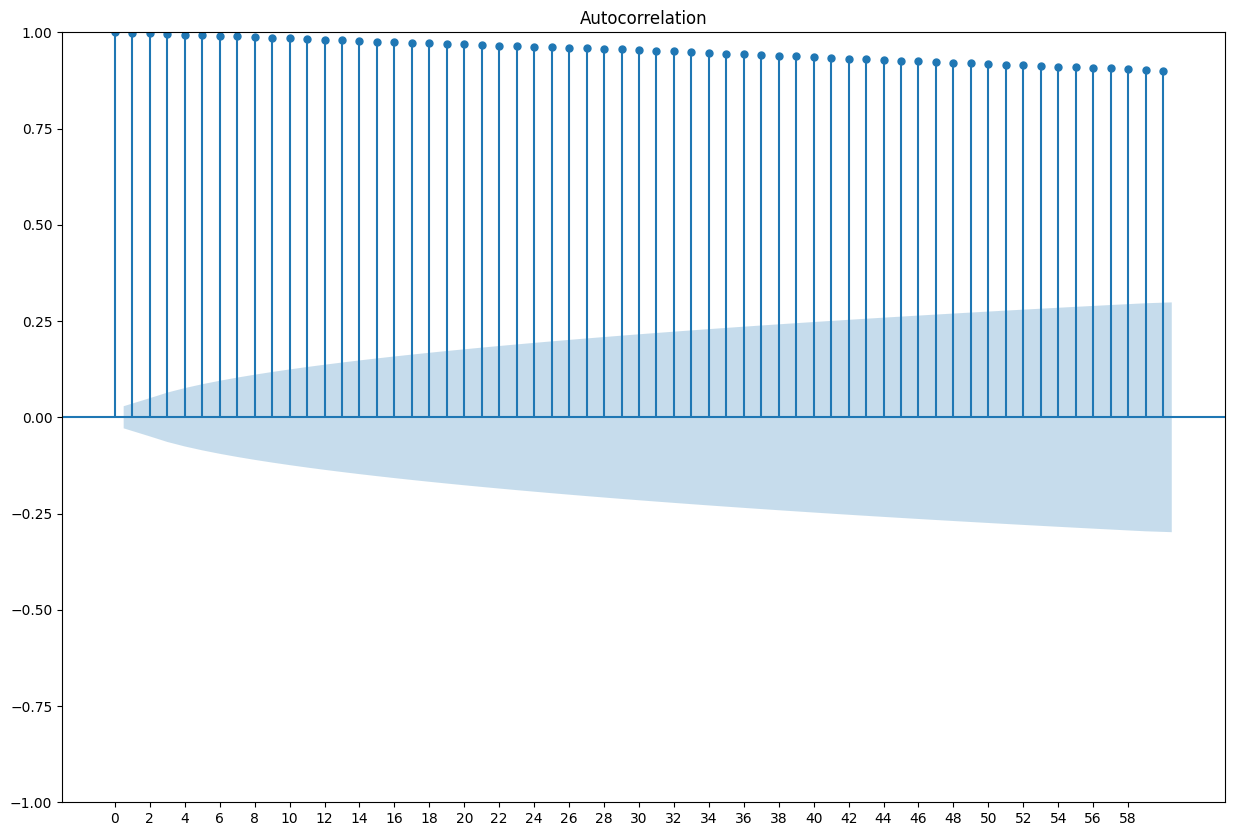

In [29]:
# plotting ACF (Auto Correlation Function) test result, to determinate Lags 

_temp = df.groupby(["Date"]).daily_close.sum().reset_index()
_temp = _temp.set_index('Date')

fig, ax = plt.subplots(figsize=(15,10)) # Increase plot size
fig = sm.graphics.tsa.plot_acf(_temp.values.squeeze(), lags=60, ax=ax) # shows ACF test result
ax.set_xticks(range(0,60, 2)) # change X axis ticks to show every 2 numbers
fig.show() # show figure

C:\Users\cmgui\AppData\Local\Temp\ipykernel_24236\3627963659.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show() # show figure


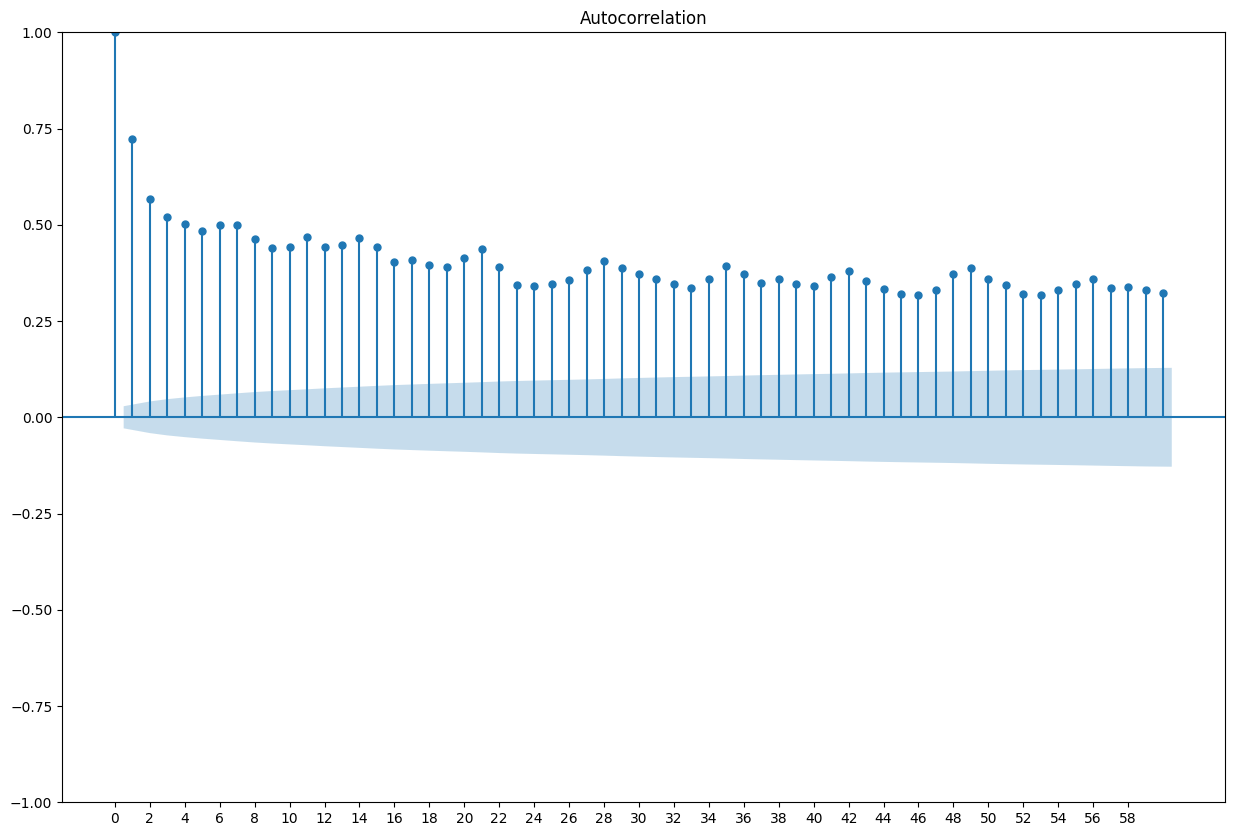

In [30]:
# plotting ACF (Auto Correlation Function) test result, to determinate Lags 

_temp = df.groupby(["Date"]).daily_volume.sum().reset_index()
_temp = _temp.set_index('Date')

fig, ax = plt.subplots(figsize=(15,10)) # Increase plot size
fig = sm.graphics.tsa.plot_acf(_temp.values.squeeze(), lags=60, ax=ax) # shows ACF test result
ax.set_xticks(range(0,60, 2)) # change X axis ticks to show every 2 numbers
fig.show() # show figure

<span style="color: lightblue; font-size: 14px;">Comments:</span>

Lag Conclusion: The most relevants lags were
- Price (1, 2, 3, 4, 5, Sequential...)
- Volume(1, 2, 3, 4, 5, 7, 8, 12, 16, ...)

In [31]:
def create_lag(df, column, values):
    cols = []
    for val in values:
        df[F"{column}_lag_{val}"] = df[column].shift(val)
        cols.append(F"{column}_{val}")
    df.bfill(inplace=True) # remove initial NaN lag
    return (df, cols)

In [32]:
price_lag_list = list(range(1, 10, 1))
volume_lag_list = list(range(1, 6, 1)) + ([7, 8, 12, 16])


print(price_lag_list)
print(volume_lag_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 7, 8, 12, 16]


Create the most relevant lags for each variable

#### Rolling

In [33]:
# define a function to create rolling variables
def create_rolling(df, column, values=[3, 7, 14]):
    cols = []
    for val in values:
        df[F"{column}_ma_{val}d"] = df[column].rolling(window=3).mean()
        cols.append(F"{column}_{val}")
    df.bfill(inplace=True) # remove initial NaN lag
    return (df, cols)

#### Correlations

In [34]:
correlation_matrix = df.drop(columns=['Date']).corr()
daily_close_corr = correlation_matrix['daily_close'].drop('daily_close')
daily_close_corr.sort_values(ascending=False)

daily_open              1.000000
daily_high              1.000000
daily_low               1.000000
weekday                -0.000158
price_per_unit         -0.018605
high_low_variation     -0.030257
open_close_variation   -0.057565
daily_volume           -0.304312
Name: daily_close, dtype: float64

In [35]:
correlation_matrix = df.drop(columns=['Date']).corr()
daily_close_corr = correlation_matrix['daily_volume'].drop('daily_volume')
daily_close_corr.sort_values(ascending=False)

high_low_variation      0.761745
open_close_variation    0.101862
price_per_unit         -0.021688
weekday                -0.113328
daily_high             -0.304216
daily_open             -0.304311
daily_close            -0.304312
daily_low              -0.304413
Name: daily_volume, dtype: float64

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- We can see that high and low variation is positively correlated with the volume of transactioned crypte.
- Daily volume can help out identifying the Price as well, with a negative correlation

### Baseline Model

In [20]:
# lags
df['lag_volume'] = df['daily_volume'].shift(1)
df['lag_close'] = df['daily_close'].shift(1)

# rolling features (e.g., 3-day moving average)
df['rolling_volume_3d'] = df['daily_volume'].rolling(window=3).mean()
df['rolling_close_3d'] = df['daily_close'].rolling(window=3).mean()

In [21]:
# train test split sequential
split_point = int(len(df) * 0.8)
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

# prepare features (X) and targets (y) for training and testing
X_train = train_data[['lag_volume', 'lag_close', 'rolling_volume_3d', 'rolling_close_3d']].copy()
X_train.bfill(inplace=True) # remove initial NaN lag
y_volume_train = train_data['daily_volume']
y_close_train = train_data['daily_close']

X_test = test_data[['lag_volume', 'lag_close', 'rolling_volume_3d', 'rolling_close_3d']].copy()
X_test.bfill(inplace=True) # remove initial NaN lag
y_volume_test = test_data['daily_volume']
y_close_test = test_data['daily_close']


In [22]:
# Training baseline linear models

# Train the model for volume prediction
volume_model = LinearRegression()
volume_model.fit(X_train, y_volume_train)

# Train the model for closing price prediction
close_model = LinearRegression()
close_model.fit(X_train, y_close_train)

# Predict on the test set
volume_pred = volume_model.predict(X_test)
close_pred = close_model.predict(X_test)

# Calculate the Mean Squared Error for both models
volume_rmse = root_mean_squared_error(y_volume_test, volume_pred)
close_rmse = root_mean_squared_error(y_close_test, close_pred)

print(f'Volume Prediction RMSE: {volume_rmse}')
print(f'Closing Price Prediction RMSE: {close_rmse}')


Volume Prediction RMSE: 917.6894255186985
Closing Price Prediction RMSE: 696.3652706893312


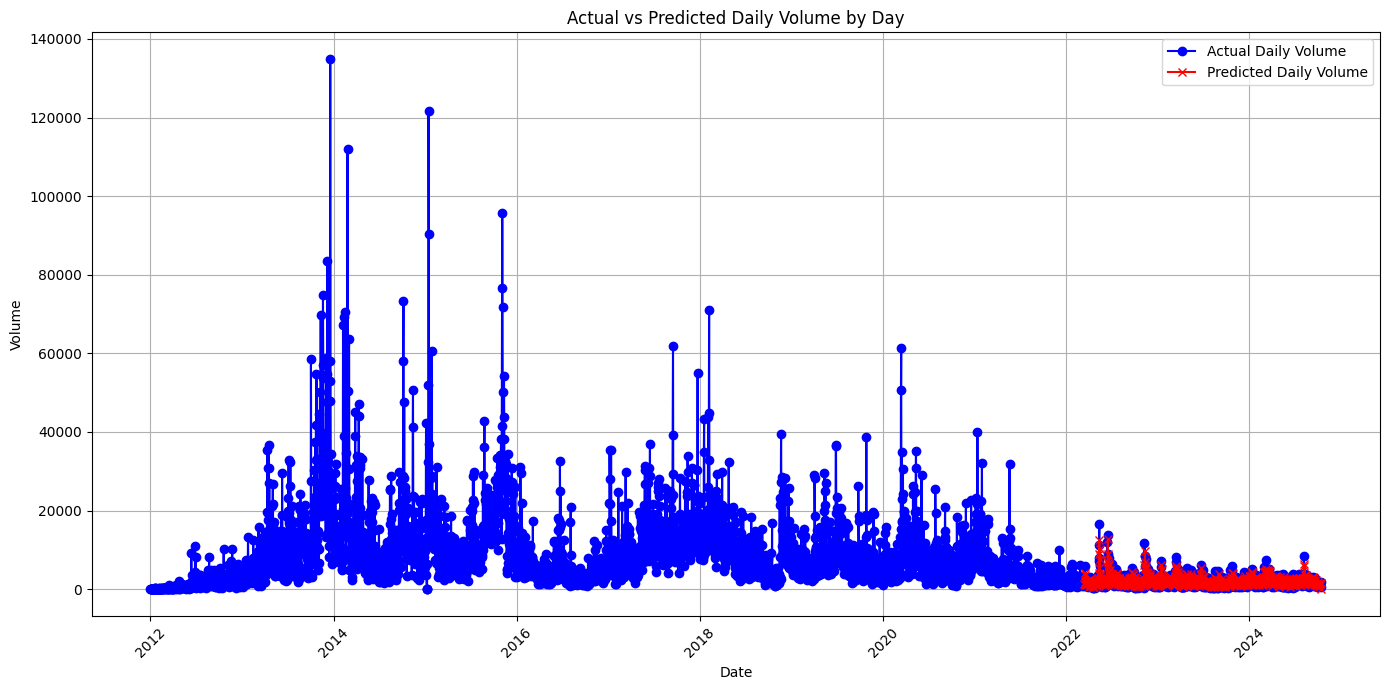

In [23]:
df['Predicted_Volume'] = pd.Series(volume_model.predict(X_test), index=y_volume_test.index)

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['daily_volume'], label='Actual Daily Volume', color='blue', linestyle='-', marker='o')
plt.plot(df['Date'], df['Predicted_Volume'], label='Predicted Daily Volume', color='red', linestyle='-', marker='x')
plt.title('Actual vs Predicted Daily Volume by Day')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


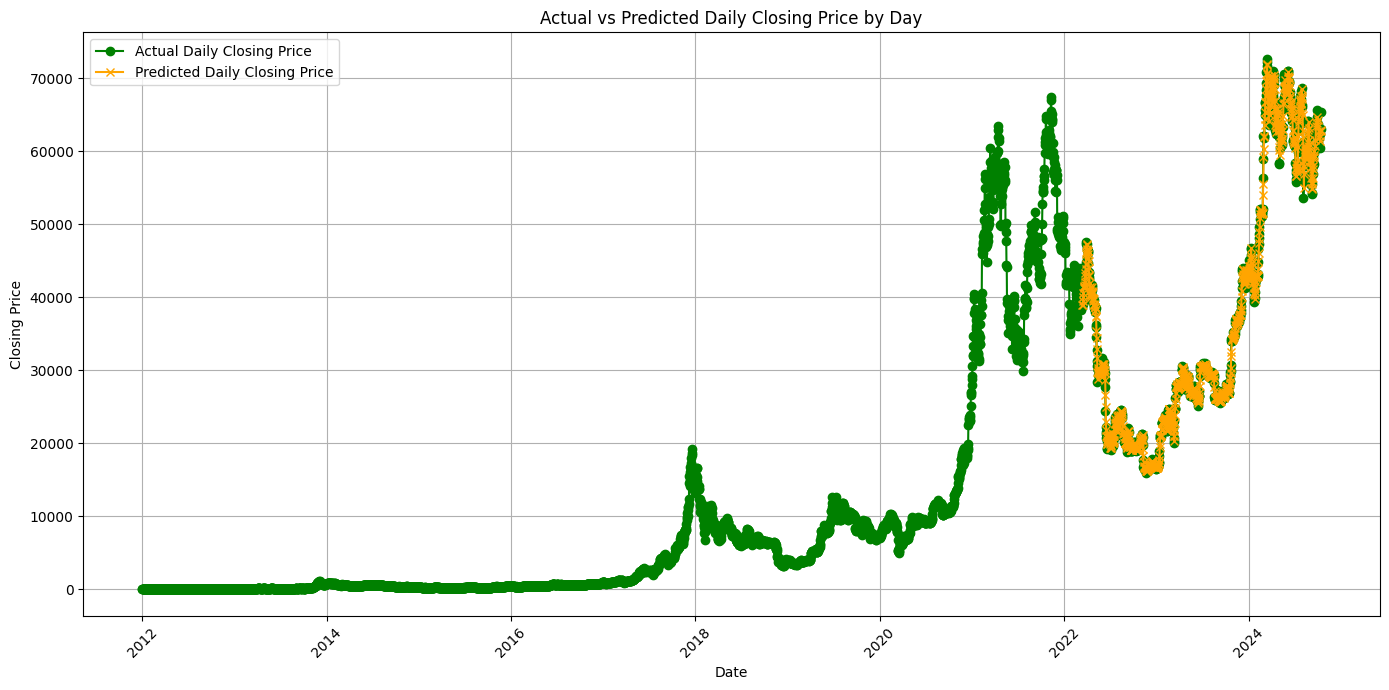

In [24]:
df['Predicted_Close'] = pd.Series(close_model.predict(X_test), index=y_close_test.index)

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['daily_close'], label='Actual Daily Closing Price', color='green', linestyle='-', marker='o')
plt.plot(df['Date'], df['Predicted_Close'], label='Predicted Daily Closing Price', color='orange', linestyle='-', marker='x')
plt.title('Actual vs Predicted Daily Closing Price by Day')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [25]:
# Save Models
save_model(volume_model, 'Linear_Regression_Volume', volume_rmse)
save_model(close_model, 'Linear_Regression_Price', close_rmse)

### Model Selection

##### LSTM

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- LSTM is a strong model to predict sequential data, so I started picking this model

In [26]:
df = base_df.copy() # reset df
df.tail(3)

,Date,daily_low,daily_high,daily_open,daily_close,daily_volume,weekday,price_per_unit,high_low_variation,open_close_variation
4654,2024-10-10,60379.760,60411.991,60396.056,60396.135,1548.286908,3,39.008361,1.000534,0.999999
4655,2024-10-12,63026.938,63038.125,63031.602,63033.355,532.545093,5,118.362474,1.000177,0.999972
4656,2024-10-14,65394.562,65432.651,65412.473,65415.258,1741.216049,0,37.568720,1.000582,0.999957


In [27]:
# Create lags
(df, price_lag_cols) = create_lag(df, 'daily_close', price_lag_list)
(df, volume_lag_cols) = create_lag(df, 'daily_volume',volume_lag_list)

# Create rollings
(df, price_rol_cols) = create_rolling(df, 'daily_close')
(df, volume_rol_cols) = create_rolling(df, 'daily_volume')

df.tail(3)

,Date,daily_low,daily_high,daily_open,daily_close,daily_volume,weekday,price_per_unit,high_low_variation,open_close_variation,...,daily_volume_lag_7,daily_volume_lag_8,daily_volume_lag_12,daily_volume_lag_16,daily_close_ma_3d,daily_close_ma_7d,daily_close_ma_14d,daily_volume_ma_3d,daily_volume_ma_7d,daily_volume_ma_14d
4654,2024-10-10,60379.760,60411.991,60396.056,60396.135,1548.286908,3,39.008361,1.000534,0.999999,...,1494.996099,1231.799602,1613.624303,2408.517111,61719.771000,61719.771000,61719.771000,1075.570931,1075.570931,1075.570931
4655,2024-10-12,63026.938,63038.125,63031.602,63033.355,532.545093,5,118.362474,1.000177,0.999972,...,437.920054,1494.996099,2952.066532,2559.694311,61926.467667,61926.467667,61926.467667,1008.781243,1008.781243,1008.781243
4656,2024-10-14,65394.562,65432.651,65412.473,65415.258,1741.216049,0,37.568720,1.000582,0.999957,...,1357.639501,437.920054,1135.128309,752.185677,62948.249333,62948.249333,62948.249333,1274.016017,1274.016017,1274.016017


In [28]:
df.columns

Index(['Date', 'daily_low', 'daily_high', 'daily_open', 'daily_close',
       'daily_volume', 'weekday', 'price_per_unit', 'high_low_variation',
       'open_close_variation', 'daily_close_lag_1', 'daily_close_lag_2',
       'daily_close_lag_3', 'daily_close_lag_4', 'daily_close_lag_5',
       'daily_close_lag_6', 'daily_close_lag_7', 'daily_close_lag_8',
       'daily_close_lag_9', 'daily_volume_lag_1', 'daily_volume_lag_2',
       'daily_volume_lag_3', 'daily_volume_lag_4', 'daily_volume_lag_5',
       'daily_volume_lag_7', 'daily_volume_lag_8', 'daily_volume_lag_12',
       'daily_volume_lag_16', 'daily_close_ma_3d', 'daily_close_ma_7d',
       'daily_close_ma_14d', 'daily_volume_ma_3d', 'daily_volume_ma_7d',
       'daily_volume_ma_14d'],
      dtype='object')

Price

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- It's important to scale the features for this model in specific, because of the vanishing gradient problem, besides all the features that I used were in the same scale

In [29]:
scaler_price = StandardScaler()

price_features = [
    'daily_close_lag_1',
    'daily_close_ma_3d', 
    'daily_low', 
    'daily_high',
    'daily_open',
    'price_per_unit'
    ]

price_target = ['daily_close']

In [30]:
# Set feature and target
features = df[price_features]
target = df[price_target]

In [31]:
# Normalize the features and target
scaler_features = StandardScaler()
scaler_target = StandardScaler()

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target)

In [32]:
# Define a function to create sequences for the LSTM
def create_lstm_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(target[i + time_steps, 0])
    return np.array(X), np.array(y)

# Define the number of time steps (look-back window)
time_steps = 3  # For example, use data from the past 7 days to predict the next day's closing price

# Create LSTM sequences
X, y = create_lstm_sequences(scaled_features, scaled_target, time_steps)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [33]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], time_steps, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], time_steps, X_test.shape[2]))

In [34]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predicting the daily_close

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2952 - val_loss: 0.0411
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0256 - val_loss: 0.0330
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - val_loss: 0.0125
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0076
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.0131
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0083
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0057
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - val_loss: 0.0091
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.0057
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0122 - val_loss: 0.0046
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097 - val_loss: 0.0051
Epoch 12/100
117/117 ━━━━━━━━━━━━━━━━━━━━

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- By observing the loss variation, the model is clearly overfitting the data due it's power.
- Maybe there isn't enough data to fit a RNN, or the selection of the features isn't the best

In [35]:
# Make predictions
predicted_close = model.predict(X_test)

# Inverse transform the predicted values to original scale
predicted_close = scaler_target.inverse_transform(predicted_close.reshape(-1, 1))

# Inverse transform the actual test values
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Root Mean Squared Error: 1271.3226153197513


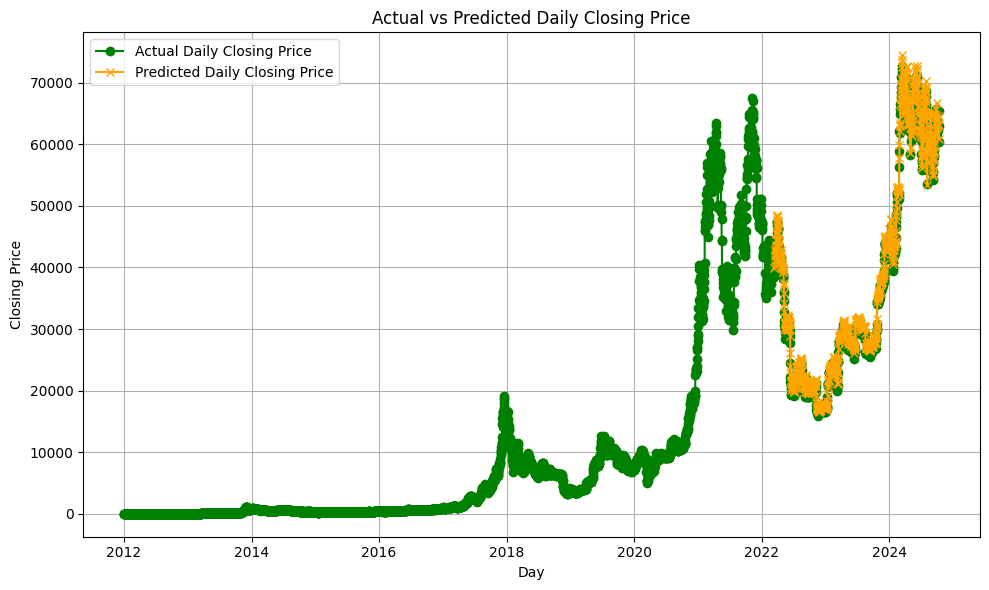

In [36]:
df['Predicted_Close'] = pd.Series(predicted_close.ravel(), index=df[train_size+3:].index)

# Calculate R Mean Squared Error
rmse = root_mean_squared_error(y_test_actual, predicted_close)
print(f'Root Mean Squared Error: {rmse}')

# Plotting Actual vs Predicted Closing Prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['daily_close'], label='Actual Daily Closing Price', color='green', linestyle='-', marker='o')
plt.plot(df['Date'], df['Predicted_Close'], label='Predicted Daily Closing Price', color='orange', linestyle='-', marker='x')
plt.title('Actual vs Predicted Daily Closing Price')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
save_model(model, 'LSTM_Price', rmse, True)

Volume

In [63]:
scaler_volume = StandardScaler()

volume_features = [
    'daily_volume_lag_1',
    'daily_volume_ma_3d', 
    'high_low_variation'
    ]

volume_target = ['daily_volume']

In [64]:
features = df[volume_features]
target = df[volume_target]

# Normalize the features and target
scaler_features = StandardScaler()
scaler_target = StandardScaler()

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target)

In [65]:
# Define the number of time steps (look-back window)
time_steps = 3  # For example, use data from the past 7 days to predict the next day's closing price

# Create LSTM sequences
X, y = create_lstm_sequences(scaled_features, scaled_target, time_steps)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], time_steps, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], time_steps, X_test.shape[2]))

In [66]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predicting the daily_close

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8574 - val_loss: 0.0434
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6641 - val_loss: 0.0318
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6171 - val_loss: 0.0383
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6292 - val_loss: 0.0373
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6740 - val_loss: 0.0295
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6576 - val_loss: 0.0272
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5870 - val_loss: 0.0250
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6310 - val_loss: 0.0257
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5365 - val_loss: 0.0270
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6058 - val_loss: 0.0272
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5846 - val_loss: 0.0222
Epoch 12/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [67]:
# Make predictions
predicted_volume = model.predict(X_test)

# Inverse transform the predicted values to original scale
predicted_volume = scaler_target.inverse_transform(predicted_volume.reshape(-1, 1))

# Inverse transform the actual test values
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Root Mean Squared Error: 1926.1606324409256


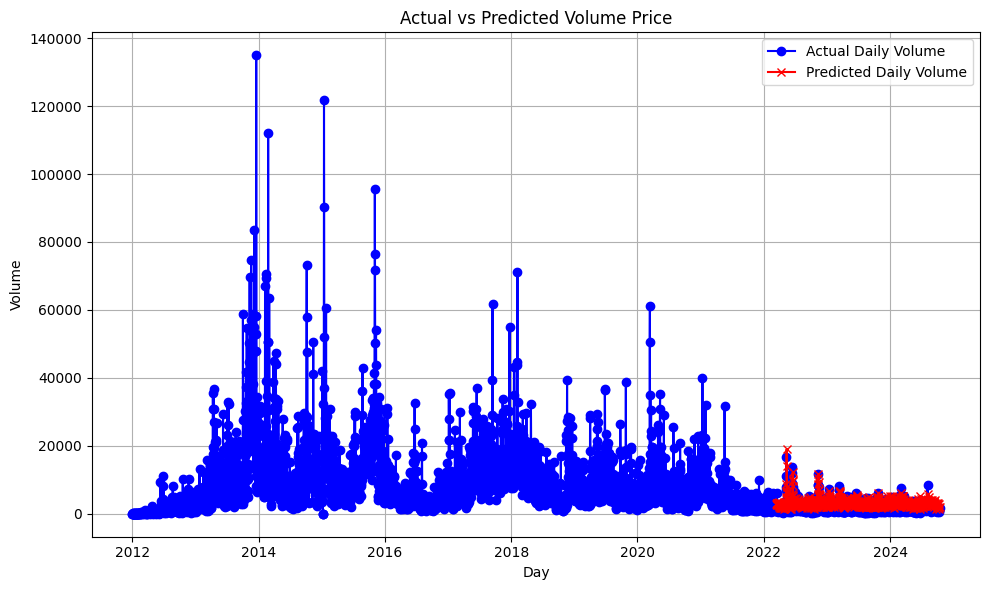

In [68]:
df['Predicted_Volume'] = pd.Series(predicted_volume.ravel(), index=df[train_size+3:].index)

# Calculate R Mean Squared Error
rmse = root_mean_squared_error(y_test_actual, predicted_volume)
print(f'Root Mean Squared Error: {rmse}')

# Plotting Actual vs Predicted Closing Prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['daily_volume'], label='Actual Daily Volume', color='blue', linestyle='-', marker='o')
plt.plot(df['Date'], df['Predicted_Volume'], label='Predicted Daily Volume', color='red', linestyle='-', marker='x')
plt.title('Actual vs Predicted Volume Price')
plt.xlabel('Day')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
save_model(model, 'LSTM_Volume', rmse, True)

#### ARIMA

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- Trying a ARIMA model now, that is also very common to do forecasting

Price

In [78]:
target = df['daily_close']

In [79]:
# Train-test split (keeping the last 20% of data for testing)
train_size = int(len(target) * 0.8)
train_data = target[:train_size]
test_data = target[train_size:]

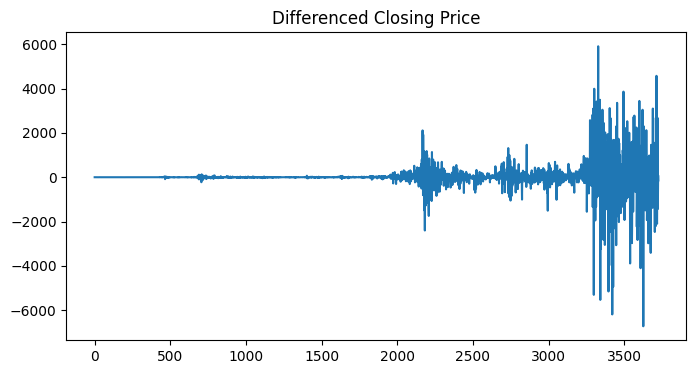

In [83]:
# Check stationarity with differencing (if the data is not already stationary)
diff_data = train_data.diff().dropna()

# Plot differenced data to see stationarity
plt.figure(figsize=(8, 4))
plt.plot(diff_data)
plt.title('Differenced Closing Price')
plt.show()

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- to use ARIMA, the dataset should be stationary, and this dataset with long-term is not, as we can see in the graph above. So I will be discarting this model for now, and use it in a short-term

#### Prophet

Price

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- Prophet is very simple and doesn't requires a stationary dataset

In [105]:
# Prophet expects the columns 'ds' for Date and 'y' for the target value
df_prophet = df[['Date', 'daily_close']].rename(columns={'Date': 'ds', 'daily_close': 'y'})

# Train-test split (80% for training)
train_size = int(len(df_prophet) * 0.8)
train_data = df_prophet[:train_size]
test_data = df_prophet[train_size:]

In [106]:
# Initialize the Prophet model
prophet_model = Prophet()

# Fit the model
prophet_model.fit(train_data)

11:17:30 - cmdstanpy - INFO - Chain [1] start processing
11:17:30 - cmdstanpy - INFO - Chain [1] done processing


In [107]:
# Make a future DataFrame that extends into the test set period
future_dates = prophet_model.make_future_dataframe(periods=len(test_data))

# Make predictions for the future dates
forecast = prophet_model.predict(future_dates)

# Show the forecasted results
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4652,2024-09-26,119747.958322,108147.037680,131382.554404
4653,2024-09-27,119784.110276,106848.244991,132039.551866
4654,2024-09-28,119891.519084,108152.017359,131820.985299
4655,2024-09-29,119950.056915,107613.510828,132865.420809
4656,2024-09-30,120095.447761,108203.914761,132552.938032


- yhat: The predicted values
- yhat_lower, yhat_upper: uncertainty intervals

In [112]:
# Extract the predicted values corresponding to the test data dates
predicted_close = forecast.iloc[test_data.index]['yhat'].values
actual_close = test_data['y'].values

rmse = root_mean_squared_error(actual_close, predicted_close)
print(f"Test RMSE: {rmse}")

Test RMSE: 54051.0375683047


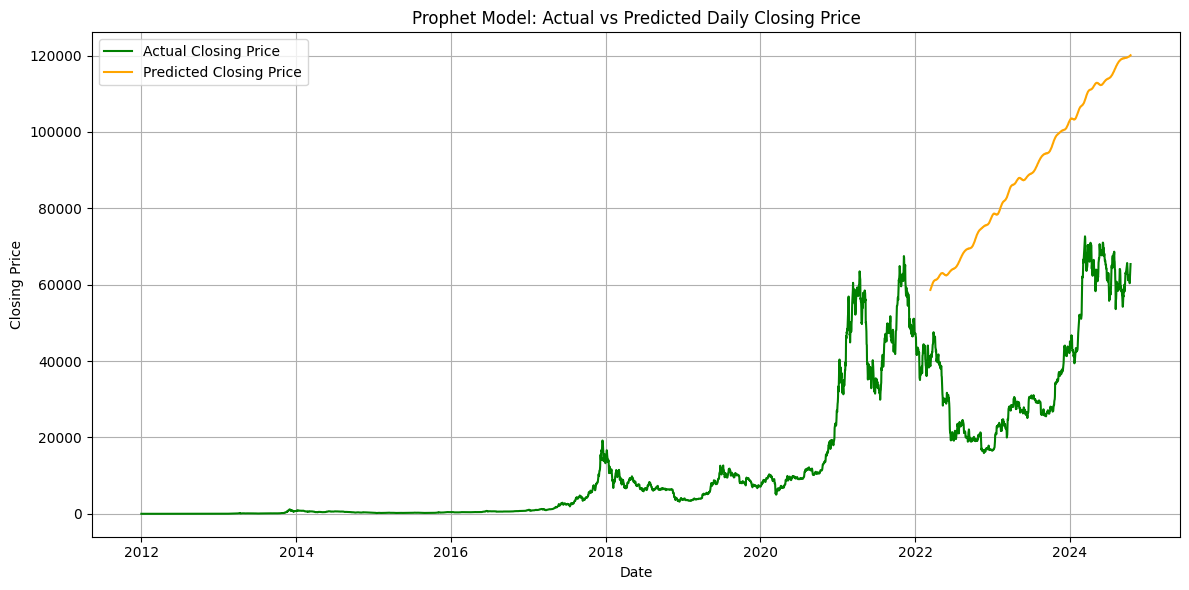

In [116]:
df['Predicted_Close'] = pd.Series(predicted_close.ravel(), index=test_data.index)

# Plot the actual vs predicted prices by date
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['daily_close'], label='Actual Closing Price', color='green')
plt.plot(df['Date'], df['Predicted_Close'], label='Predicted Closing Price', color='orange')
plt.title('Prophet Model: Actual vs Predicted Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- The results were not satisfying, maybe the model is too simple to identify the patterns for the bitcoin as it is now

#### Random Forest

Price

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- Random forest is a powerful model, I tried different sets of variables for the Price, and this were the best ones

In [196]:
price_features = [
    'daily_close_lag_1',
#   'daily_close_lag_2',
#    'daily_close_lag_3',
   'daily_close_ma_3d',
#    'daily_close_ma_7d',
    'daily_low', 
    'daily_high',
    'daily_open',
    'price_per_unit',
#    'daily_volume'
    ]

X = df[price_features]
y = df['daily_close']

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [197]:
# Make predictions on the test data
predicted_close = rf_model.predict(X_test)

# RMSE
rmse = root_mean_squared_error(y_test, predicted_close)
print(f"Test RMSE: {rmse}")

Test RMSE: 719.9911698433257


<span style="color: lightblue; font-size: 14px;">Comments:</span>


- It almost perfomed as good as the linear regression for the price, maybe with a hyperparameter tunning, we can get a better model

In [147]:
save_model(rf_model, 'RandomForest_Price', rmse)

Volume

In [148]:
volume_features = [
    'daily_volume_lag_1',
    'daily_volume_ma_3d', 
    'high_low_variation',
    'daily_close'
    ]

X = df[volume_features]
y = df['daily_volume']

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [149]:
# Make predictions on the test data
predicted_volume = rf_model.predict(X_test)

# RMSE
rmse = root_mean_squared_error(y_test, predicted_volume)
print(f"Test RMSE: {rmse}")

Test RMSE: 880.1203161507559


<span style="color: lightblue; font-size: 14px;">Comments:</span>


- beated the linear regression's score for the volume prediction

In [150]:
save_model(rf_model, 'RandomForest_Volume', rmse)

### Hyperparameters Tunning

In [192]:
# created this function to analyse the short-term dataset
def filter_dataframe_by_year(df, years=1):
    # filter dataframe from 1 year from the last date
    last_date = df['Date'].max() # get the last date
    one_year_ago = last_date - pd.DateOffset(years=years) # reduce 1 year from the last date
    df = df[df['Date'] >= one_year_ago.date()].copy() # filter dataframe from 1 year from the last date
    return df

##### LSTM

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- The idea of tunning the LSTM is to see if with a smaller learning rate, maybe the NN can converge better to a better result

In [43]:
def build_lstm_model(hp):
    model = Sequential()

    # LSTM layer with hyperparameters for units (neurons)
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                   activation='relu', 
                   return_sequences=False, 
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    
    # Dropout with tunable rate
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer (predicting 'daily_close')
    model.add(Dense(1))

    # Compile the model with tunable learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(
                    hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')

    return model

In [44]:
# Set up the tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train per trial
    directory='tuning_results',  # Directory to save tuning results
    project_name='lstm_price_prediction'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The optimal number of units is {best_hps.get('units')}")
print(f"The optimal learning rate is {best_hps.get('learning_rate')}")
print(f"The optimal dropout rate is {best_hps.get('dropout_rate')}")

Reloading Tuner from tuning_results\lstm_price_prediction\tuner0.json
The optimal number of units is 96
The optimal learning rate is 0.01
The optimal dropout rate is 0.2


<span style="color: lightblue; font-size: 14px;">Comments:</span>

- **LSTM units:** neurons varying between 32 and 128, in steps of 32.
- **Dropout rate:** vary between 0.1 and 0.5
- **Learning rate:** vary between 0.01, 0.001, and 0.0001.

Even with the smaller learning rates, the model picked the highest as the best model.

In [45]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions with the best model
predicted_close = best_model.predict(X_test)

# Inverse transform predicted values to original scale
predicted_close = scaler_target.inverse_transform(predicted_close.reshape(-1, 1))


Epoch 1/100


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1023 - val_loss: 0.0263
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - val_loss: 0.0093
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261 - val_loss: 0.0187
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - val_loss: 0.0062
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0182
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - val_loss: 0.0049
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.0180
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - val_loss: 0.0113
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - val_loss: 0.0059
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0607
Epoch 12/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Root Mean Squared Error: 1289.1552271187654


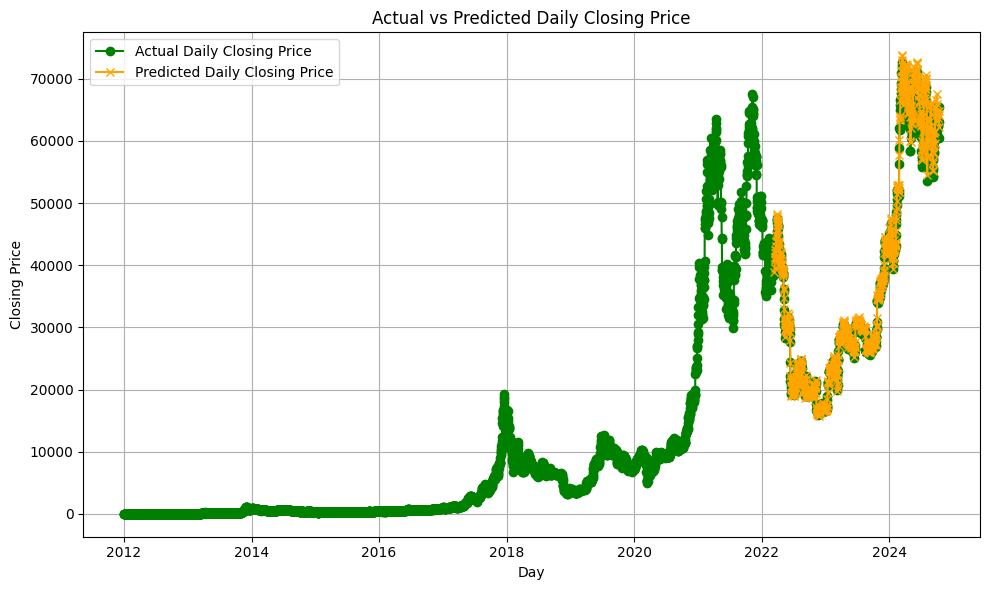

In [46]:
df['Predicted_Close'] = pd.Series(predicted_close.ravel(), index=df[train_size+3:].index)

# Calculate R Mean Squared Error
rmse = root_mean_squared_error(y_test_actual, predicted_close)
print(f'Root Mean Squared Error: {rmse}')

# Plotting Actual vs Predicted Closing Prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['daily_close'], label='Actual Daily Closing Price', color='green', linestyle='-', marker='o')
plt.plot(df['Date'], df['Predicted_Close'], label='Predicted Daily Closing Price', color='orange', linestyle='-', marker='x')
plt.title('Actual vs Predicted Daily Closing Price')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
save_model(best_model, 'LSTM_Price', rmse, True)

##### Random Forest

Price

In [151]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300, 500, 800, 1000],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],             # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],             # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],               # Minimum samples to be at a leaf node
    'max_features': ['auto', 'sqrt'],            # Number of features to consider at each split
    'bootstrap': [True, False]                   # Whether to bootstrap samples or not
}

In [152]:
price_features = [
    'daily_close_lag_1',
    'daily_close_ma_3d',
    'daily_low', 
    'daily_high',
    'daily_open',
    'price_per_unit'
    ]

X = df[price_features]
y = df['daily_close']

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [162]:
# Set up RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(),
                               param_distributions=param_grid,
                               n_iter=100,  # Number of random combinations to try
                               cv=3,        # Cross-validation folds
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)   # Use all available cores

# Fit RandomizedSearchCV on the training data
rf_random.fit(X_train, y_train)

# Print the best parameters
print(f"Best Parameters: {rf_random.best_params_}")

# Get the best model
best_rf_model = rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
121 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [163]:
# Predict on the test data with the best model
predicted_close = best_rf_model.predict(X_test)

# RMSE
rmse = root_mean_squared_error(y_test, predicted_close)
print(f"Test RMSE: {rmse}")

Test RMSE: 708.1750945005125


In [164]:
save_model(best_rf_model, 'RandomForest_Price', rmse)

Root Mean Squared Error: 708.1750945005125


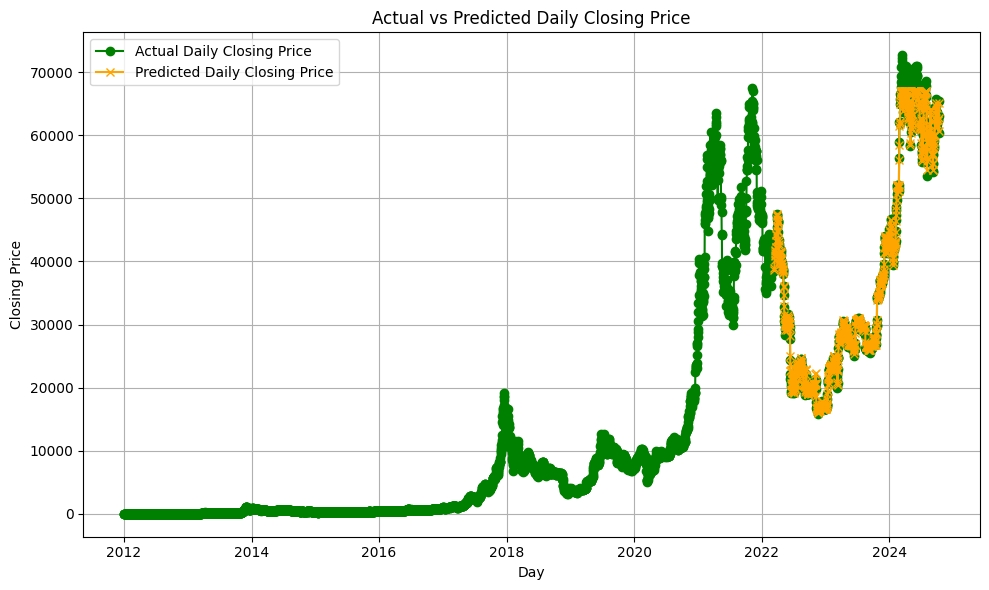

In [170]:
df['Predicted_Close'] = pd.Series(predicted_close.ravel(), index=X_test.index)

# Calculate R Mean Squared Error
rmse = root_mean_squared_error(y_test, predicted_close)
print(f'Root Mean Squared Error: {rmse}')

# Plotting Actual vs Predicted Closing Prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['daily_close'], label='Actual Daily Closing Price', color='green', linestyle='-', marker='o')
plt.plot(df['Date'], df['Predicted_Close'], label='Predicted Daily Closing Price', color='orange', linestyle='-', marker='x')
plt.title('Actual vs Predicted Daily Closing Price')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Volume

In [171]:
volume_features = [
    'daily_volume_lag_1',
    'daily_volume_ma_3d', 
    'high_low_variation',
    'daily_close'
    ]

X = df[volume_features]
y = df['daily_volume']

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [186]:
# Set up RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(),
                               param_distributions=param_grid,
                               n_iter=100,  # Number of random combinations to try
                               cv=3,        # Cross-validation folds
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)   # Use all available cores

# Fit RandomizedSearchCV on the training data
rf_random.fit(X_train, y_train)

# Print the best parameters
print(f"Best Parameters: {rf_random.best_params_}")

# Get the best model
best_rf_model = rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
61 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_

Best Parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [188]:
# Predict on the test data with the best model
predicted_volume = best_rf_model.predict(X_test)

# RMSE
rmse = root_mean_squared_error(y_test, predicted_volume)
print(f"Test RMSE: {rmse}")

Test RMSE: 854.1989799089987


Root Mean Squared Error: 854.1989799089987


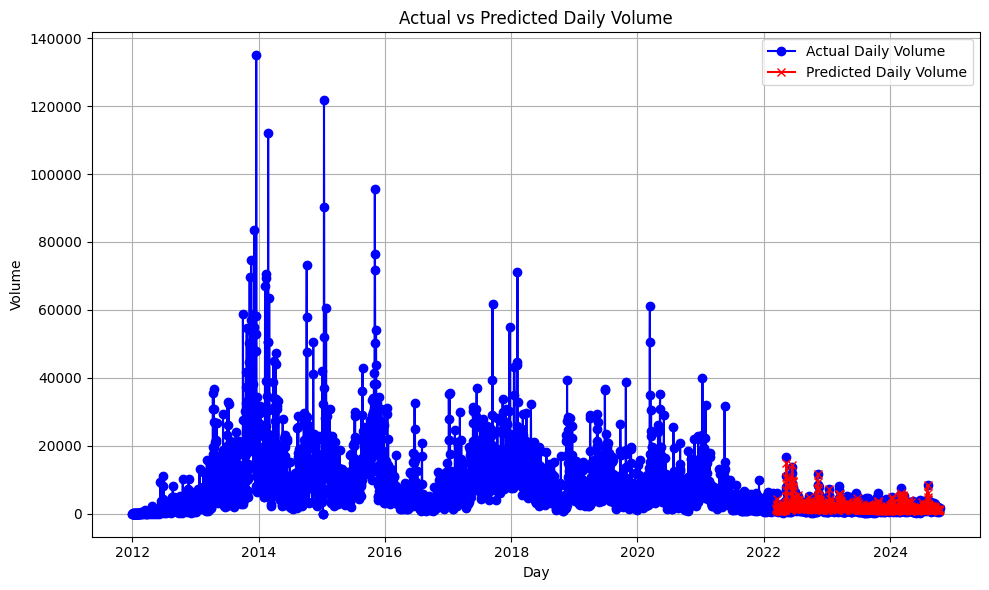

In [190]:
df['Predicted_Volume'] = pd.Series(predicted_volume.ravel(), index=X_test.index)

# Calculate R Mean Squared Error
rmse = root_mean_squared_error(y_test, predicted_volume)
print(f'Root Mean Squared Error: {rmse}')

# Plotting Actual vs Predicted Closing Prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['daily_volume'], label='Actual Daily Volume', color='blue', linestyle='-', marker='o')
plt.plot(df['Date'], df['Predicted_Volume'], label='Predicted Daily Volume', color='red', linestyle='-', marker='x')
plt.title('Actual vs Predicted Daily Volume')
plt.xlabel('Day')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [191]:
save_model(best_rf_model, 'RandomForest_Volume', rmse)

<span style="color: lightblue; font-size: 14px;">Comments:</span>


- We could get better results with paramters tunning in the RF, but still couldn't beat the linear regression for the price prediction, only for the volume

##### Linear Regression

There is not much to tune in the linear regression, but i will try L1, L2 and Elasticnet, and changing features

In [205]:
price_features = [
    'daily_close_lag_1',
    'daily_close_ma_3d', 
    'daily_low', 
    'daily_high',
    'daily_open',
    'daily_volume'
    ]

price_target = ['daily_close']

X = df[price_features]
y = df[price_target]

# Split the data into train and test sets
train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model for closing price prediction
close_model = LinearRegression()
close_model.fit(X_train, y_train)

close_pred = close_model.predict(X_test)

# Calculate the Mean Squared Error for both models
close_rmse = root_mean_squared_error(y_test, close_pred)

print(f'Closing Price Prediction RMSE: {close_rmse}')

Closing Price Prediction RMSE: 0.7078294316112825


<span style="color: lightblue; font-size: 14px;">Comments:</span>


- 0.7 RMSE, Overfit

Ridge

In [212]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
close_pred = ridge_model.predict(X_test)
close_rmse = root_mean_squared_error(y_test, close_pred)

print(f'Closing Price Prediction RMSE: {close_rmse}')

Closing Price Prediction RMSE: 0.7077741653896804


<span style="color: lightblue; font-size: 14px;">Comments:</span>


- Overfit

Lasso

In [214]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
close_pred = lasso_model.predict(X_test)
close_rmse = root_mean_squared_error(y_test, close_pred)

print(f'Closing Price Prediction RMSE: {close_rmse}')

Closing Price Prediction RMSE: 278.4883343224387


<span style="color: lightblue; font-size: 14px;">Comments:</span>


- Lasso regularization gave good results over ridge because there are few variables that are useful for prediction, so it behaves better

In [216]:
save_model(lasso_model, 'Lasso_Price', close_rmse)

In [222]:
volume_features = [
    'daily_volume_lag_1',
    'daily_volume_ma_3d', 
    'high_low_variation',
 #   'daily_close'
    ]

X = df[volume_features]
y = df['daily_volume']

# Split the data into train and test sets
train_size = int(len(X) * 0.8) # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model for closing price prediction
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
volume_pred = lasso_model.predict(X_test)
volume_rmse = root_mean_squared_error(y_test, volume_pred)

print(f'Volume Prediction RMSE: {volume_rmse}')

Volume Prediction RMSE: 807.3611721272468


In [223]:
save_model(lasso_model, 'Lasso_Volume', volume_rmse)

ElasticNet

In [215]:
en_model = ElasticNet()
en_model.fit(X_train, y_train)
close_pred = en_model.predict(X_test)
close_rmse = root_mean_squared_error(y_test, close_pred)

print(f'Closing Price Prediction RMSE: {close_rmse}')

Closing Price Prediction RMSE: 278.4880982850004


<span style="color: lightblue; font-size: 14px;">Comments:</span>


- EN combines both L1 (Lasso) and L2 (Ridge) regularization, and in this case will behave like L1

<span style="color: #D70040; font-size: 17px;">Final Models:</span>

In the time available to this task, staying with the Lasso's best models:

- Price: <span style="color: lightgreen; font-size: 17px;">Lasso_Price_RMSE_278.pkl</span>
- Volume: <span style="color: lightgreen; font-size: 17px;">Lasso_Volume_RMSE_807.pkl</span>

There were a lot of different things that could be done, that will be described in *README.txt*